# Collected data

In [1]:
from feature_extraction import *
from nice_plots import *

In [2]:
data = pd.read_csv("data3.csv")
data

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall
...,...,...,...,...,...,...,...
96795,7.30,-1.16,-4.58,18.19,3.60,-35.77,light
96796,7.39,-0.37,-5.05,20.08,0.06,-34.55,light
96797,7.52,-1.46,-5.82,22.58,0.12,-28.02,light
96798,7.58,-2.14,-6.31,19.47,2.44,-22.52,light


# Explicit preprocessing

In [3]:
flat_data = flatten_ts(data)
flat_data

,xAcc_1,xAcc_2,xAcc_3,xAcc_4,xAcc_5,xAcc_6,xAcc_7,xAcc_8,xAcc_9,xAcc_10,...,zGyro_392,zGyro_393,zGyro_394,zGyro_395,zGyro_396,zGyro_397,zGyro_398,zGyro_399,zGyro_400,label
0,6.99,6.51,6.22,6.34,6.49,6.55,6.27,6.67,6.79,6.72,...,-0.67,-1.10,-1.34,-1.28,-1.04,-0.98,-0.98,-0.98,-1.10,fall
1,6.89,6.61,6.48,6.45,6.75,6.90,6.70,6.55,6.47,6.64,...,-0.43,-0.73,-0.85,-1.04,-1.04,-1.34,-0.79,-0.92,-0.67,fall
2,5.92,5.89,5.83,5.89,5.94,5.90,5.79,5.88,6.02,5.98,...,22.77,23.86,26.43,34.36,39.92,39.67,37.78,38.09,36.19,fall
3,6.88,6.49,6.41,6.09,5.62,5.67,7.41,12.76,7.47,6.55,...,0.06,3.05,1.46,-3.05,-3.78,-4.94,-4.21,-2.56,1.40,fall
4,6.56,6.12,6.17,6.41,6.35,5.88,5.36,5.16,12.62,9.95,...,-16.78,-24.23,-29.91,-28.75,-20.26,-9.89,-9.58,-18.62,-35.58,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,6.59,6.94,7.21,6.72,6.58,6.51,6.77,8.18,10.87,8.51,...,-6.47,-1.59,4.27,-4.70,-15.20,-17.40,-12.88,-16.66,-23.13,light
238,6.86,6.81,6.63,6.60,6.41,7.32,9.05,9.84,8.77,7.39,...,-14.71,-22.28,-26.18,-31.07,-37.66,-48.46,-50.66,-35.52,-21.06,light
239,6.78,8.19,7.49,7.53,6.69,8.30,8.30,7.21,6.68,6.70,...,16.24,18.68,18.80,18.31,14.28,5.86,4.33,15.14,24.60,light
240,8.42,8.20,7.70,8.13,8.70,8.70,8.16,7.48,7.65,7.78,...,-7.08,-10.86,-10.62,-5.62,1.71,11.35,15.69,18.62,22.95,light


In [4]:
warnings.filterwarnings('ignore')
df, labels = vec_sum(flat_data)
df["label"] = labels
df

,acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10,...,gyr_392,gyr_393,gyr_394,gyr_395,gyr_396,gyr_397,gyr_398,gyr_399,gyr_400,label
0,10.108581,9.537688,9.185761,9.317725,9.264567,9.625679,9.470449,9.866560,9.931556,9.772226,...,0.832226,1.108152,1.508940,1.350296,1.384558,1.316586,1.062873,0.996393,1.218113,fall
1,9.642505,9.398622,9.307653,9.317312,9.578157,9.677939,9.672518,9.602609,9.526610,9.640954,...,0.755910,1.080139,1.166619,1.393198,1.229349,1.508575,1.302728,1.196746,1.042785,fall
2,9.661987,9.639725,9.577270,9.591632,9.661698,9.597072,9.501800,9.647844,9.755275,9.684782,...,36.741091,35.978113,39.397108,45.323665,50.354353,51.365726,49.815388,50.785400,42.545700,fall
3,9.480295,8.876773,8.682062,8.864181,8.687900,8.705142,9.638350,17.116331,10.001335,8.002706,...,5.678010,9.178181,9.709485,7.585269,6.007537,6.188667,5.522871,6.093423,10.975719,fall
4,9.567241,9.223112,9.656159,9.535397,9.125322,8.799966,8.890231,9.637935,15.429051,11.867860,...,25.946726,28.139966,31.458948,28.856559,20.350327,9.901773,10.485676,20.769095,45.044041,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9.170093,9.273748,9.343463,9.500316,9.085670,9.075230,9.275139,11.338188,12.609592,10.298942,...,24.157347,14.040239,4.396464,12.434846,38.257195,49.500611,52.183440,56.153815,51.446970,light
238,9.022505,9.271451,9.181166,9.263369,9.303322,9.903297,11.889706,12.140906,10.008227,8.930291,...,16.680126,22.309641,26.740989,36.154228,52.353129,67.389355,65.728835,38.954941,21.060769,light
239,7.912073,9.007675,8.720384,10.116961,9.617723,10.637171,10.104375,9.309882,9.280781,9.631895,...,27.804604,30.426965,30.604902,30.377567,24.071066,8.991780,5.798396,17.283695,27.881836,light
240,9.129847,8.806730,9.078882,10.509943,10.325803,9.800066,9.796203,9.374711,9.540325,9.469789,...,14.292617,14.283893,12.658535,6.578982,7.462721,15.174574,18.183570,21.144408,29.404588,light


# Plotting time

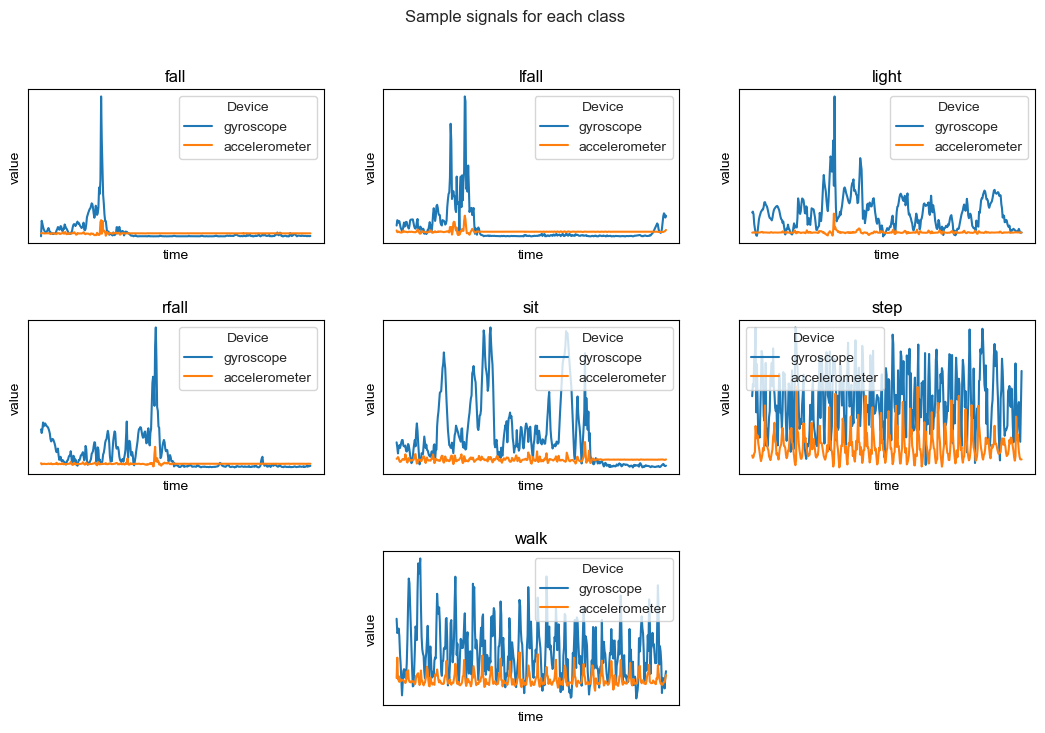

In [5]:
# Select one row for each different label class
sampled_rows = df.groupby('label').apply(lambda x: x.sample(1, random_state=123))

signal_plot(sampled_rows)

### FFT Magnitude

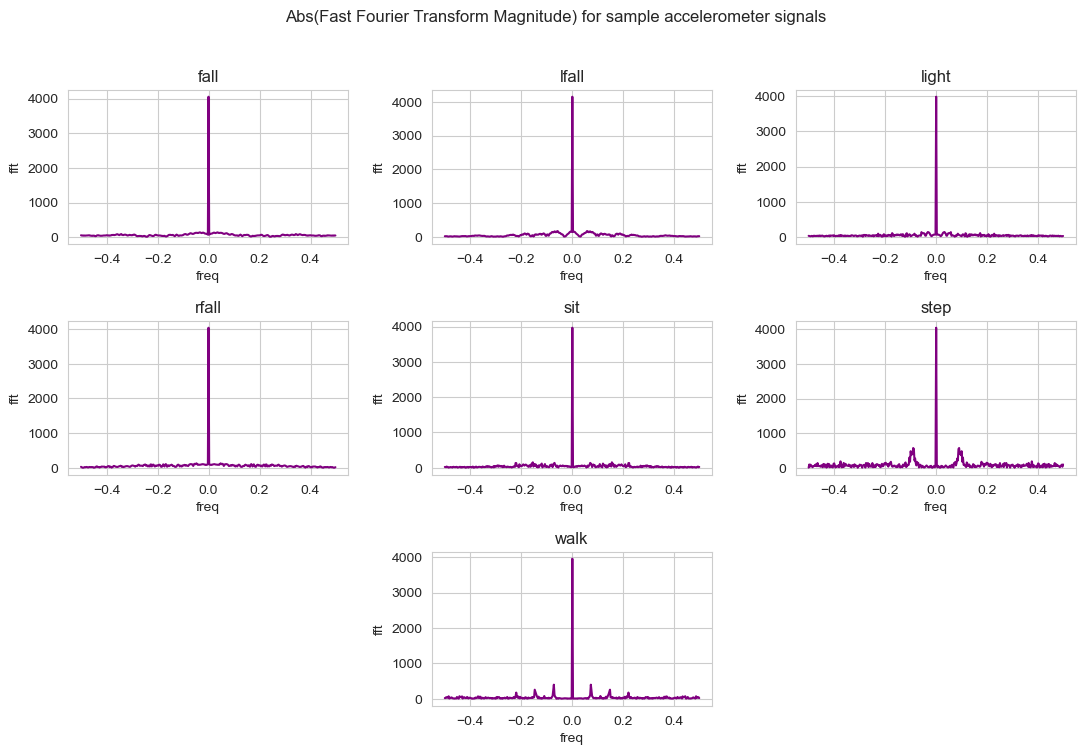

In [6]:
fft_plot(sampled_rows, "accelerometer")

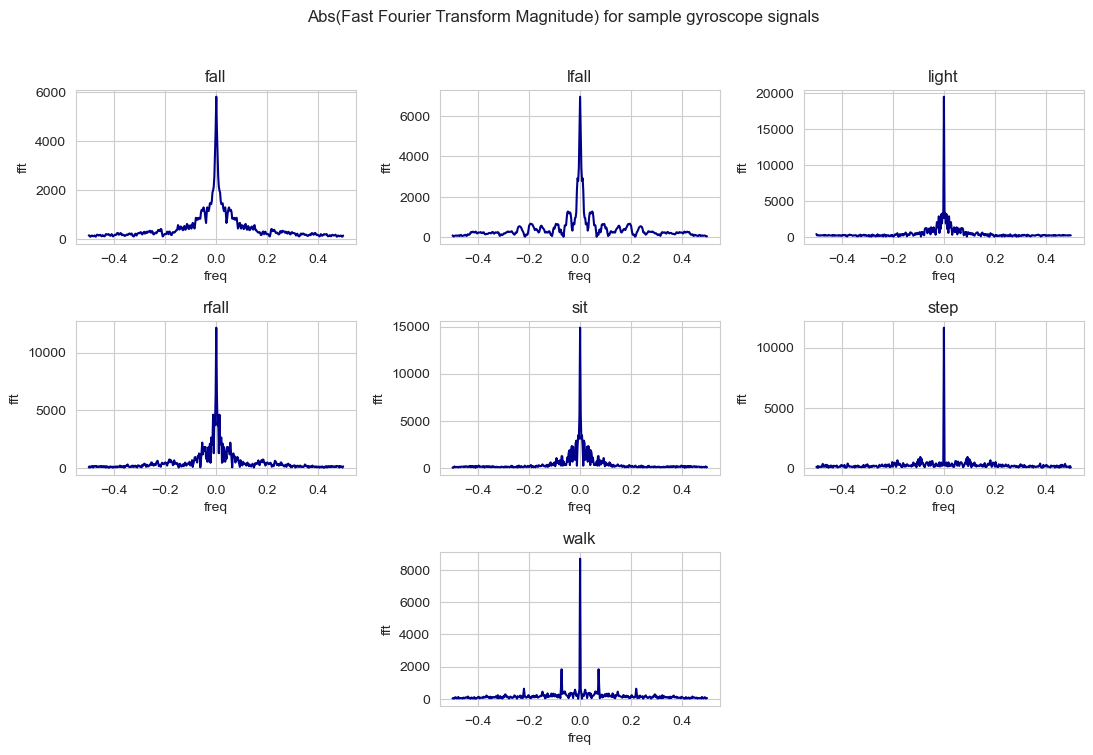

In [7]:
fft_plot(sampled_rows, "gyroscope")

### Power spectrum peaks

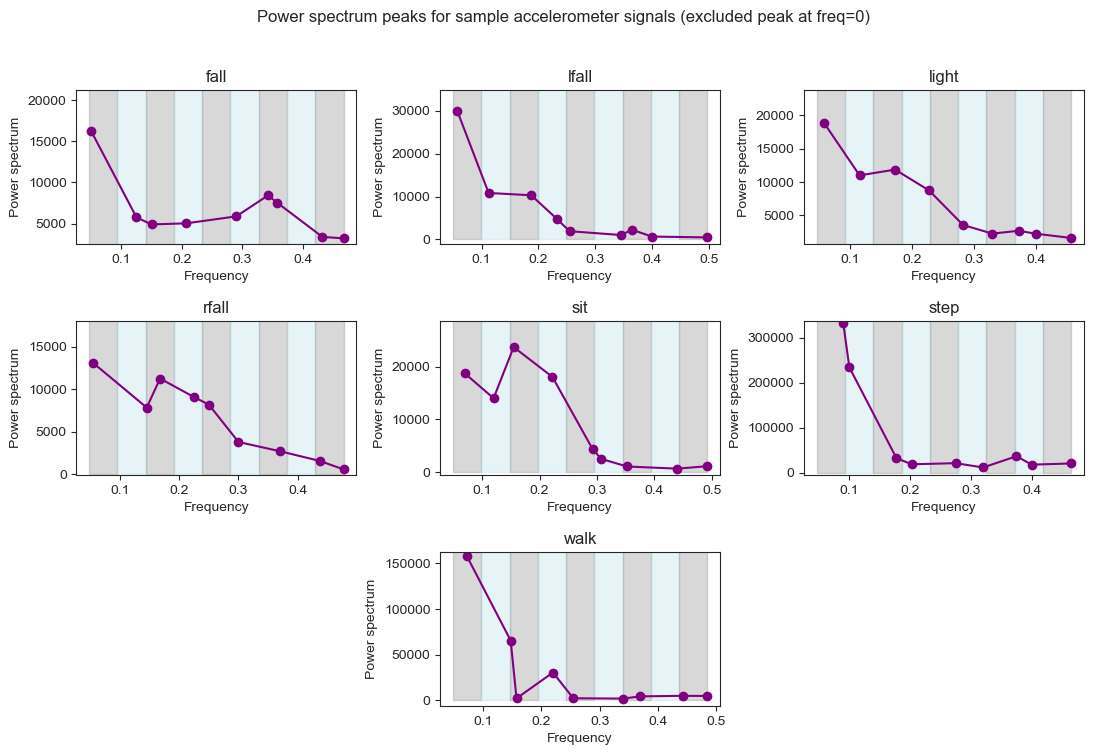

In [8]:
maxbin_plot(sampled_rows, "accelerometer")

Note that for the accelerometer the magnitude at frequence=0 is the same for each type of signal. This is not true for the gyroscope since it seems that for every signal has a peak at freq=0 BUT this peak has different magnitude in each case

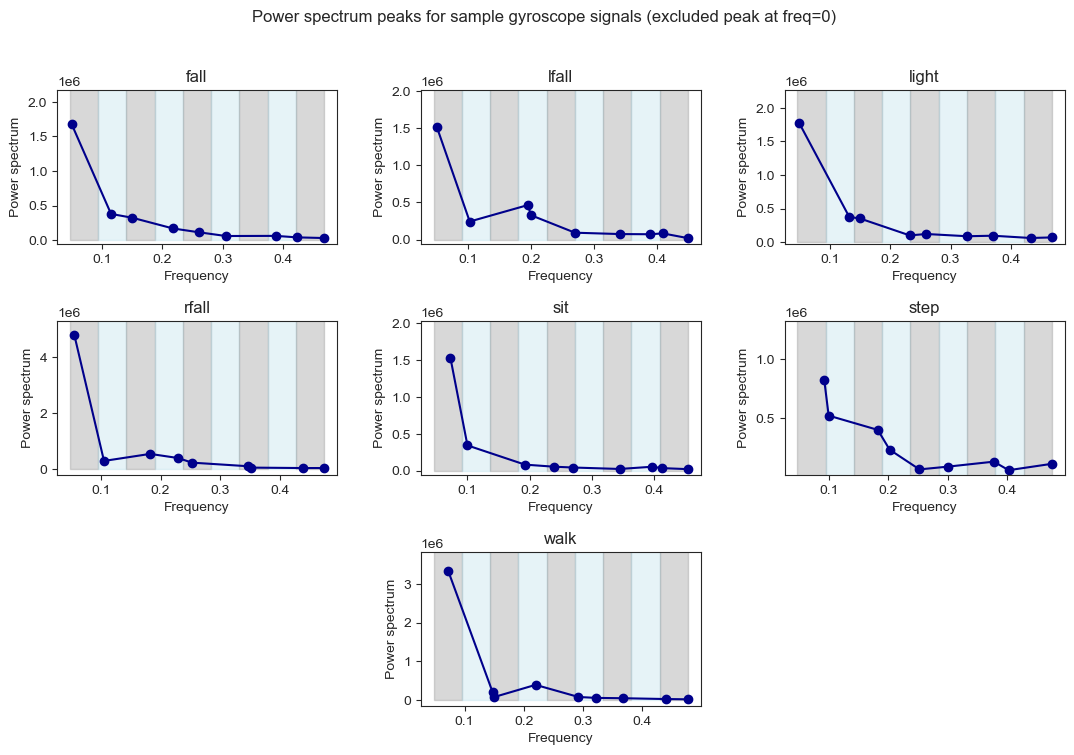

In [9]:
maxbin_plot(sampled_rows, "gyroscope")

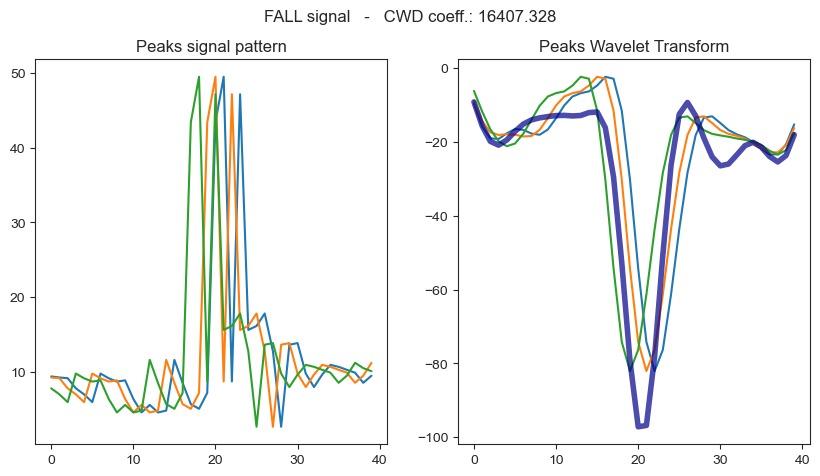

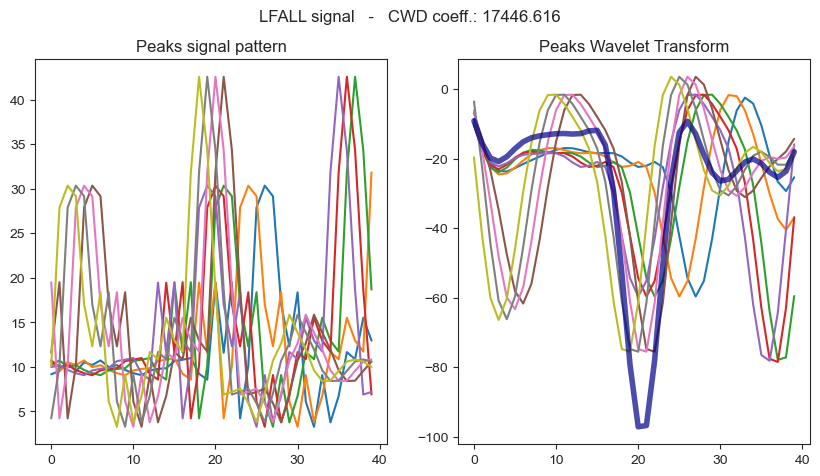

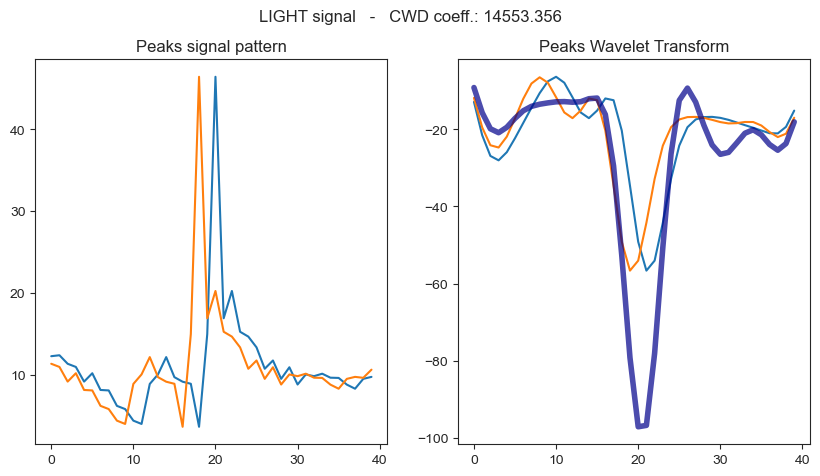

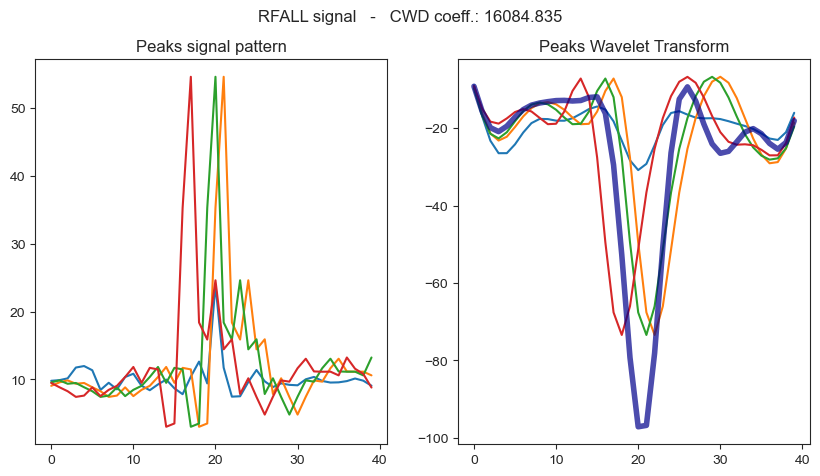

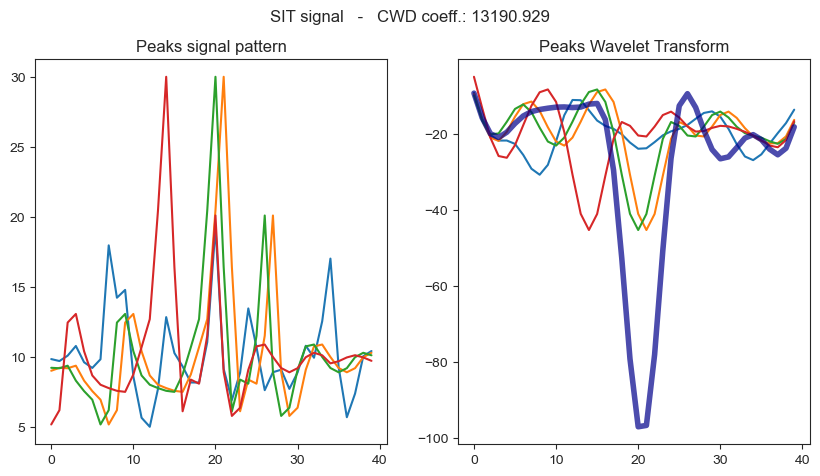

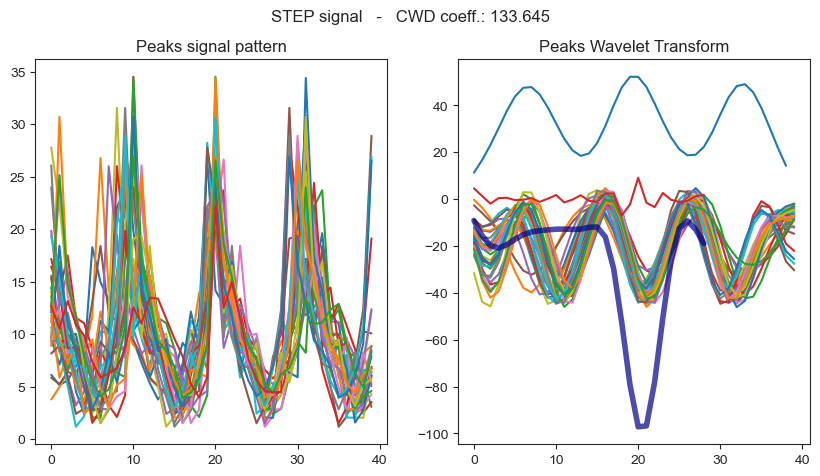

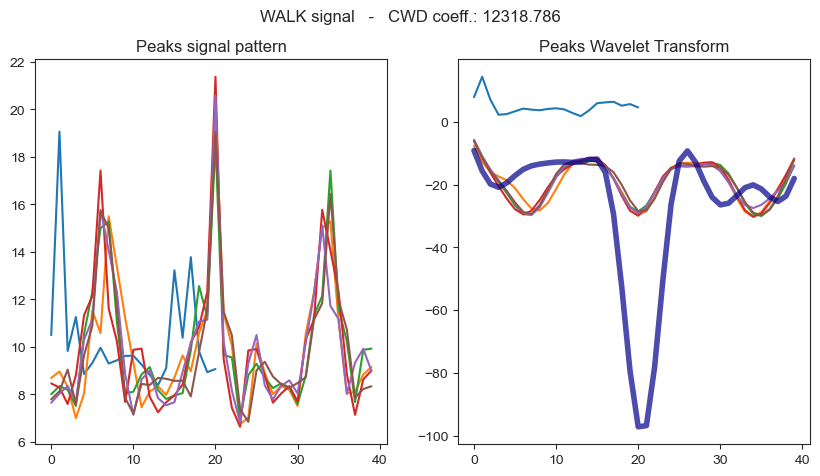

In [10]:
mother_wave = extract_wave_df("file_csv")

for label, row in sampled_rows.iterrows():
    vec = np.array(row[:-1], dtype=np.float32)[:400]
    res = peakes_wavelet_approx(vec, mother_wave, True, label[0])

# Final preprocessed data set

In [4]:
prova = preproc(data, 15)
prova

,acc_max_mag_1,acc_max_mag_2,acc_max_mag_3,acc_max_mag_4,acc_max_mag_5,gyr_max_mag_1,gyr_max_mag_2,gyr_max_mag_3,gyr_max_mag_4,gyr_max_mag_5,acc_psd1,acc_psd2,acc_psd3,gyr_psd1,gyr_psd2,gyr_psd3,cwt_coeff,label
0,1.679561e+07,18721.154353,7100.335747,15443.379045,11696.480495,1.077492e+08,5.017116e+06,6.787773e+05,2.100723e+05,511951.143950,7.264484,21.605317,2.266248,335.528281,6683.819118,10.060861,17895.547497,fall
1,1.666644e+07,17096.038339,5345.825318,22126.371544,16797.181146,2.970916e+08,5.963252e+06,1.876670e+06,6.657685e+05,465629.751594,9.428514,19.359462,1.741056,525.734259,8445.535938,12.842785,16992.656384,fall
2,1.690417e+07,22413.999497,14913.810039,18483.969593,13990.673765,4.304287e+08,8.412478e+06,1.644419e+06,7.335214e+05,671668.798449,11.073100,25.433874,1.874920,296.404199,6752.523845,8.763110,16037.018822,fall
3,1.690057e+07,18798.728822,27834.293492,58377.754093,30326.288200,5.162937e+08,9.091154e+06,1.965535e+06,6.057332e+05,683876.245125,9.131326,26.921273,3.127359,348.643022,8965.268444,10.819895,12731.303696,fall
4,1.742747e+07,17572.669139,99254.848523,124734.902539,34418.850456,3.574267e+08,3.717381e+06,2.053406e+06,1.452541e+06,843492.824657,12.425194,31.434656,6.207779,668.548802,6688.750331,9.785420,15162.129894,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,1.638037e+07,20099.923295,7037.623252,11433.622947,7151.947063,3.005802e+08,1.076573e+07,3.910192e+06,7.194042e+05,389663.003137,6.840570,15.026079,2.081657,153.232435,4807.971407,5.426481,16233.858823,light
238,1.660464e+07,15692.281489,14302.864306,19305.212301,4545.408630,3.665159e+08,5.740845e+06,1.563710e+06,5.912486e+05,565309.135195,5.550793,11.241446,2.417584,227.597167,5924.778843,5.529446,12721.569249,light
239,1.612340e+07,25131.303791,14680.610706,5905.058076,7903.859218,2.961041e+08,5.159878e+06,1.533535e+06,1.211368e+06,795695.965727,10.788574,15.292856,2.242325,238.547673,5273.231796,5.532851,16415.380260,light
240,1.613424e+07,11934.645653,6998.180669,9199.815170,15515.727474,4.060575e+08,3.279267e+06,1.497185e+06,1.246336e+06,217021.252937,3.716582,11.827115,2.076557,203.839857,4587.081041,8.481311,15761.040305,light


In [5]:
prova.columns

Index(['acc_max_mag_1', 'acc_max_mag_2', 'acc_max_mag_3', 'acc_max_mag_4',
       'acc_max_mag_5', 'gyr_max_mag_1', 'gyr_max_mag_2', 'gyr_max_mag_3',
       'gyr_max_mag_4', 'gyr_max_mag_5', 'acc_psd1', 'acc_psd2', 'acc_psd3',
       'gyr_psd1', 'gyr_psd2', 'gyr_psd3', 'cwt_coeff', 'label'],
      dtype='object')

In [6]:
labels = prova["label"]
df_binary = prova.copy()
prova = prova.drop("label", axis=1)

# Binary classification (Naive Bayes vs Logistic regression)

In this section, we compare the performance of two models belonging to two different categories of machine learning models: discriminative and generative.
In brief, discriminative models target either to model $p(y|x)$ directly (i.e. as logistic regression does), or to learn a direct map from the inputs to the class variable (i.e. as perceptron does).
Generative models, on the other hand, try to model $p(x|y)$ and $p(y)$ (aka the likelihood and the prior distributions) and they make predictions by using the Bayes rule taht allows to derive $p(y|x)$.


In this project, we compare the performance of logistic regression (representant of the discriminative category) and naive Bayes(representat of the generative category).
Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. 
Naive Bayes models assume the conditional independency of the predictors, assumption which is not always true. 
Since naive Bayes models raise additional assumptions w.r.t. the logistic regression, they should be trated as a quick-and-dirty baseline for a classification problem.
In fact, if we are not dealing with particular constraints in terms of both time and information (number of observation), we should prevent fromm using this type of models.

There are many flavours of naive Bayes models but, for our purposes, we focus our attention on the Gaussian naive Bayes model. 
In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution.

In [12]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, f1_score
# CV based searching for first and future models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB

We have to map our seven classes to two classes in order to perform a binary classification ("fall" or "normal")

In [8]:
# Mapping for relabeling
label_mapping = {
    'fall' :'fall',
    'rfall': 'fall',
    'lfall': 'fall',
    'light': 'fall',
    'sit': 'normal',
    'walk': 'normal',
    'step': 'normal'
}

# Replace existing labels with new labels
df_binary['label'] = df_binary['label'].map(label_mapping)

In [9]:
y = df_binary["label"]
df_binary = df_binary.drop("label", axis=1)

In [10]:
# split data 
seed = 1218
X_train, X_test, y_train, y_test = train_test_split(prova, y, test_size=0.3, random_state=seed)

# scale the features (may be useful if we are going to add other features with different scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

In [11]:
model = GaussianNB()
model.fit(X_train_scaled,y_train)
preds = model.predict(X_test_scaled)
accuracy_score(y_test, preds)

0.9726027397260274

In [12]:
logistic_clf = LogisticRegression()

logistic_cv = KFold(logistic_clf, n_splits=5, n_repeats=10, random_state=None)

NameError: name 'KFold' is not defined

# Softmax regression

In [19]:
# labels
y = labels
seed = 1218
# split data 
X_train, X_test, y_train, y_test = train_test_split(prova, y, test_size=0.3, random_state=seed)

# scale the features (may be useful if we are going to add other features with different scale)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float64))
X_test = scaler.fit_transform(X_test.astype(np.float64))


We simply fit of a Softmax regression since we have seven different classes that we want to predict. So we specify the "multinomial" attribute for our Scikit-learn model, and we use the "lbfgs" (Limited-memory BFGS) optimization algorithm as solver with $L_2$ default regularization

In [20]:
# softmax regression
softmax = LogisticRegression(multi_class="multinomial", solver="lbfgs")
softmax.fit(X_train, y_train)
sm_preds = softmax.predict(X_test)

accuracy_score(y_test, sm_preds)

0.9041095890410958

Let's compare our results without regularization... the model seems to not well generalize... so it is better to insist with l2 penalty (the only one "legal" in combo with our solver). 

In [21]:
softmax_nr = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty=None)
softmax_nr.fit(X_train, y_train)
sm_preds1 = softmax_nr.predict(X_test)

accuracy_score(y_test, sm_preds1)

0.8356164383561644

We can try to inspect the generalization performances (approximated by a K-Fold Cross-Validation) for different values of the penalization coefficient $\lambda$ in the the Ridge Classifier. The results show that, on average, the performance in terms of accuracy is maximized relatively slow levels of penalization coefficient.

(0.0, 400.0)

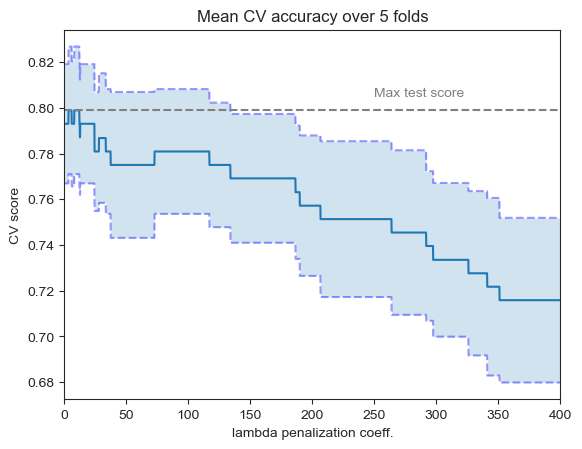

In [64]:
ridge = RidgeClassifier()

lambdas = np.linspace(0, 400, 5000)

params = [{"alpha": lambdas}]
n_folds = 5

lambda_CV = GridSearchCV(ridge, params, cv=n_folds, refit=False)
lambda_CV.fit(X_train, y_train)
scores = lambda_CV.cv_results_["mean_test_score"]
scores_std = lambda_CV.cv_results_["std_test_score"]
std_error = scores_std / np.sqrt(n_folds)

plt.plot(lambdas, scores)
plt.plot(lambdas, scores + std_error, "b--", alpha=0.4)
plt.plot(lambdas, scores - std_error, "b--", alpha=0.4)
plt.fill_between(lambdas, scores + std_error, scores - std_error, alpha=0.2)
plt.text(250, 0.805, "Max test score", color="grey")
plt.title(f'Mean CV accuracy over {n_folds} folds')
plt.ylabel("CV score")
plt.xlabel("lambda penalization coeff.")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([lambdas[0], lambdas[-1]])

With this initial analysis we may simply restrict the parameters space in which look for the best choice (combination) of parameters. Let's proceed with a Randomized Search for our linear model: we can see that with this new more accurate inspection based on the F1-score optimization (max) the penalty seems to be excluded. In this case also the optimal classifier it's a different one and, using an high number of iteration of our search, the best parameters solution "converge" to the following.

In [22]:
warnings.filterwarnings('ignore')
softmax_clf = LogisticRegression(multi_class="multinomial")

sm_params = {"penalty": ["l1", "l2", "elasticnet", None],
             "max_iter": np.arange(50, 1000, 100),
             "warm_start": [True, False],
             "solver": ["lbfgs", "liblinear", "sag", "saga", "newton-cg", "newton-cholesky"],
             "class_weight": [None, "balanced"],
             "fit_intercept": [True, False]}

sm_search = RandomizedSearchCV(softmax_clf, sm_params, scoring="f1_macro", n_jobs=-1, cv=10, n_iter=1000)

sm_search.fit(X_train, y_train)
softmax_clf = sm_search.best_estimator_
softmax_clf.fit(X_train, y_train)
softmax_preds = softmax_clf.predict(X_test)

print(f'Best parameters: {sm_search.best_params_}')
print(f'Accuracy:{accuracy_score(y_test, softmax_preds)}')
print(f'F1-score:{f1_score(y_test, softmax_preds, average="macro")}')

Best parameters: {'warm_start': False, 'solver': 'sag', 'penalty': None, 'max_iter': 50, 'fit_intercept': True, 'class_weight': None}
Accuracy:0.863013698630137
F1-score:0.7973705232325923


From the report, we can identify what problems we need to solve to come up with a perfomorming model:

1. the training sample is small (80% of 242 total observations) and actually contains a small number of observations for each class

2. some particular types of falls are very similar or are directly mistaken for the "classic" forward fall ("fall"). Prominent is the case of the "light" fall being mistaken for a "fall."

3. in general we are not very PRECISE in identifying the forward fall as other samples of different falls take on characteristics similar to the first.

              precision    recall  f1-score   support

        fall       0.65      1.00      0.79        11
       lfall       1.00      0.50      0.67         2
       light       1.00      0.81      0.89        21
       rfall       0.00      0.00      0.00         1
         sit       1.00      0.95      0.97        19
        step       0.75      1.00      0.86         3
        walk       1.00      0.94      0.97        16

    accuracy                           0.89        73
   macro avg       0.77      0.74      0.73        73
weighted avg       0.92      0.89      0.89        73



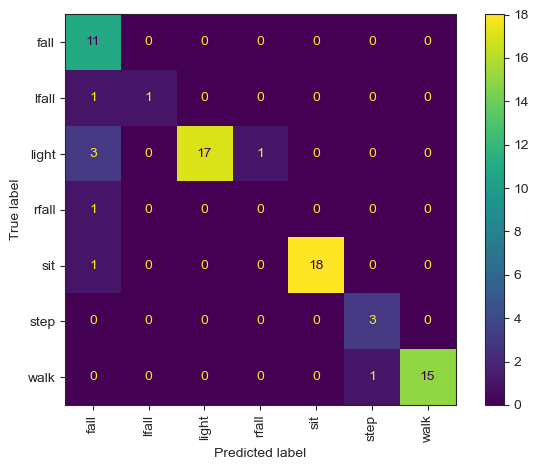

In [61]:
print(classification_report(y_test, softmax_preds, target_names=softmax_clf.classes_))
ConfusionMatrixDisplay.from_estimator(
    softmax_clf, X_test, y_test, display_labels=softmax_clf.classes_, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

# Resampling

We try to make the data set nicer for our model, since we noticed that a probable issue could be the fact that we have a little number of samples for classes that represent the different types of fall.

In [34]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import KMeans

seed=1218
sm = KMeansSMOTE(kmeans_estimator= KMeans(),random_state=seed)
y = labels
X, y = sm.fit_resample(prova, y)

# split data 
seed = 1218
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X, y, test_size=0.3, random_state=seed)

# scale the features (may be useful if we are going to add other features with different scale)
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res.astype(np.float64))
X_test_res = scaler.fit_transform(X_test_res.astype(np.float64))

In [35]:
softmax_clf_res = sm_search.best_estimator_
softmax_clf_res.fit(X_train_res, y_train_res)
softmax_preds_res = softmax_clf.predict(X_test_res)

print(f'Accuracy:{accuracy_score(y_test_res, softmax_preds_res)}')
print(f'F1-score:{f1_score(y_test_res, softmax_preds_res, average="macro")}')

Accuracy:0.918918918918919
F1-score:0.921117412714998


              precision    recall  f1-score   support

        fall       0.90      0.79      0.84        24
       lfall       0.88      0.93      0.90        15
       light       0.96      0.87      0.92        31
       rfall       0.79      1.00      0.88        19
         sit       1.00      1.00      1.00        17
        step       1.00      0.89      0.94        18
        walk       0.92      1.00      0.96        24

    accuracy                           0.92       148
   macro avg       0.92      0.93      0.92       148
weighted avg       0.93      0.92      0.92       148



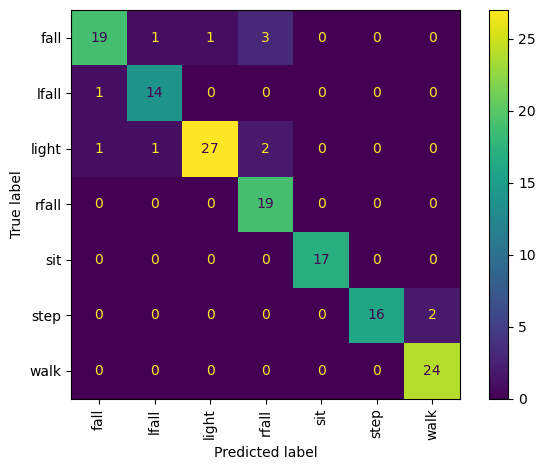

In [36]:
print(classification_report(y_test_res, softmax_preds_res, target_names=softmax_clf_res.classes_))
ConfusionMatrixDisplay.from_estimator(
    softmax_clf_res, X_test_res, y_test_res, display_labels=softmax_clf_res.classes_, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

# Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf_clf = RandomForestClassifier()

rf_params = {"n_estimators": [100, 200, 500, 50, 1000],
            "criterion": ["gini", "entropy", "log_loss", None],
            "max_depth": [None, 100, 50],
            "bootstrap": [True, False],
            "max_features": ["sqrt", "log2", None],
            }

rf_search = RandomizedSearchCV(rf_clf, rf_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=100)

rf_search.fit(X_train_res, y_train_res)

In [39]:
rf_clf = rf_search.best_estimator_
rf_clf.fit(X_train_res, y_train_res)
rf_preds = rf_clf.predict(X_test_res)

print(f'Best parameters: {rf_search.best_params_}')
print(f'Accuracy:{accuracy_score(y_test_res, rf_preds)}')
print(f'F1-score:{f1_score(y_test_res, rf_preds, average="macro")}')

Best parameters: {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}
Accuracy:0.8918918918918919
F1-score:0.8807217770829262


The radom forest seems to perform less well than the logistic, and the misclassification error oddly concentrates on the "lfall" and "light" classes differentiating itself from the previously used linear classifier which, always saw the "light" type fall as a problem class, but lost out in the distinction between "fall" and "light."

              precision    recall  f1-score   support

        fall       0.95      0.75      0.84        24
       lfall       0.90      0.60      0.72        15
       light       0.89      1.00      0.94        31
       rfall       0.72      0.95      0.82        19
         sit       1.00      1.00      1.00        17
        step       1.00      0.83      0.91        18
        walk       0.89      1.00      0.94        24

    accuracy                           0.89       148
   macro avg       0.91      0.88      0.88       148
weighted avg       0.90      0.89      0.89       148



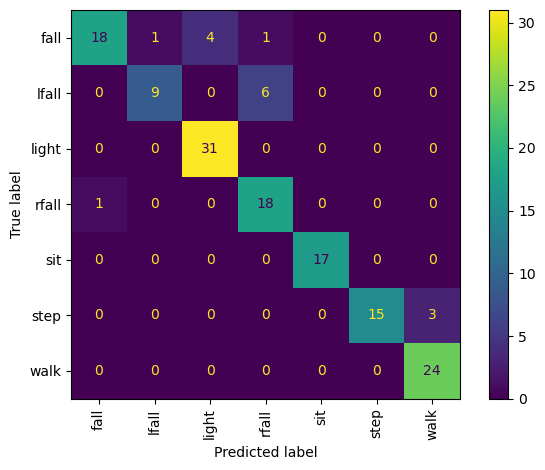

In [40]:
print(classification_report(y_test_res, rf_preds, target_names=rf_clf.classes_))
ConfusionMatrixDisplay.from_estimator(
    rf_clf, X_test_res, y_test_res, display_labels=rf_clf.classes_, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

# Simple linear model on final data set

In [62]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
preds = sgd_clf.predict(X_test)

In [63]:
accuracy_score(y_test, preds)

0.863013698630137